In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Combined model (RF)

### RIH data total = 220 cases (Hypo = 106, non = 114)

In [4]:
cli = pd.read_excel('outcome.xlsx', header = 0, index_col = 0)
cli.head()

,Hypo
ID,
1,1
2,1
3,1
4,0
5,1


In [6]:
# Defined label
label = cli.iloc[:,0]
label.head(3)

ID
1    1
2    1
3    1
Name: Hypo , dtype: int64

### Combined data 

In [7]:
data_processed = pd.read_excel('input_RF.xlsx', header = 0, index_col = 0)
data_processed.head()

,Sex,Age,N0,N2,N3,FT4_Before_RT,TSH_Before_RT,TR_Volume,TR_min,TR_max,...,v1286,v1287,Stage_1,Stage_2,Stage_3,Stage_4,Stage_5,no. of fraction_1,no. of fraction_2,no. of fraction_3
ID,,,,,,,,,,,,,,,,,,,,,
1,1,26,0,0,0,1.38,2.73,13.1,33.0,55.0,...,6126.622060,0.003526,0,1,0,0,0,0,1,0
2,2,48,0,0,0,1.26,1.68,9.9,37.1,67.7,...,18817.879752,0.002761,0,0,1,0,0,1,0,0
3,1,55,0,1,0,1.24,1.81,10.6,27.9,64.2,...,6771.603748,0.005598,0,0,0,1,0,1,0,0
4,1,56,0,0,0,1.34,0.33,14.0,37.5,55.7,...,3153.099969,0.006354,0,0,0,1,0,0,1,0
5,2,67,0,1,0,0.98,1.58,6.1,44.5,76.4,...,10645.864546,0.006218,0,0,1,0,0,0,1,0


## Split data to train:test = 80%:20%

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, label, test_size = 0.2, stratify = label, \
                                                    shuffle = True, random_state = 999) 

In [9]:
print('Train group = ',X_train.shape)
print('Test group = ', X_test.shape)

Train group =  (176, 1059)
Test group =  (44, 1059)


## Standardize data using mean and SD estimates from the training set

In [10]:
X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)

X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

## Preliminary model evaluation

In [11]:
random_forest_models = {}

for N in [50, 100, 200, 300]:
    for depth in [10, 20, None]:
        for leaf in [1, 5, 11]:
            name = 'RF-N' + str(N) + 'D' + str(depth) + 'L' + str(leaf)
            random_forest_models[name] = RandomForestClassifier(n_estimators = N, max_depth = depth, min_samples_leaf = leaf, \
                                                                random_state = 111)

In [12]:
def get_cv_results_tree(X, y, models):
    skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 111)
    cv_results = {m:{'importance':[], 'train accuracy':[], 'train AUC':[], 'confusion matrix':[], \
                     'test accuracy':[], 'test AUC':[]} for m in models}

    for train_index, val_index in skfold.split(X, y):
        X_train_cv = X.iloc[train_index, :]
        y_train_cv = y.iloc[train_index]

        X_val = X.iloc[val_index, :]
        y_val = y.iloc[val_index]

        for m in cv_results: ## Add an inner loop over the models
            model = models[m] ## Pull model from log_reg_models
            model.fit(X_train_cv, y_train_cv)

            y_fitted = model.predict_proba(X_train_cv)[:, 1]
            y_fitted_class = model.predict(X_train_cv)

            y_predict = model.predict_proba(X_val)[:, 1]
            y_predict_class = model.predict(X_val)

            ## Add [m] to point results to the dictionary entry for the current model
            cv_results[m]['importance'].append(model.feature_importances_)
            
            cv_results[m]['train accuracy'].append(accuracy_score(y_train_cv, y_fitted_class))
            cv_results[m]['train AUC'].append(roc_auc_score(y_train_cv, y_fitted))

            cv_results[m]['confusion matrix'].append(confusion_matrix(y_val, y_predict_class))
            cv_results[m]['test accuracy'].append(accuracy_score(y_val, y_predict_class))
            cv_results[m]['test AUC'].append(roc_auc_score(y_val, y_predict))
            
    return cv_results

In [13]:
cv_results = get_cv_results_tree(X_train_std, y_train, random_forest_models)

In [14]:
# validation group
models = [m for m in cv_results]
val_acc_all = [np.mean(cv_results[m]['test accuracy']) for m in cv_results]
val_auc_all = [np.mean(cv_results[m]['test AUC']) for m in cv_results]
val_acc_sd_all = [np.std(cv_results[m]['test accuracy']) for m in cv_results]
val_auc_sd_all = [np.std(cv_results[m]['test AUC']) for m in cv_results]

model_order = np.argsort(val_auc_all)[::-1]

for i in model_order:
    print(models[i], 'validation acc =', val_acc_all[i], 'validation AUC =', val_auc_all[i],
                     'validation acc sd =', val_acc_sd_all[i], 'validation AUC sd =', val_auc_sd_all[i] )

RF-N300DNoneL5 validation acc = 0.6873015873015873 validation AUC = 0.69828001375989 validation acc sd = 0.07517846407931779 validation AUC sd = 0.11206738734818127
RF-N300D20L5 validation acc = 0.6873015873015873 validation AUC = 0.69828001375989 validation acc sd = 0.07517846407931779 validation AUC sd = 0.11206738734818127
RF-N300D10L5 validation acc = 0.6873015873015873 validation AUC = 0.69828001375989 validation acc sd = 0.07517846407931779 validation AUC sd = 0.11206738734818127
RF-N200DNoneL11 validation acc = 0.6703174603174603 validation AUC = 0.6978672170622635 validation acc sd = 0.06212739778110502 validation AUC sd = 0.10052230582199062
RF-N200D10L11 validation acc = 0.6703174603174603 validation AUC = 0.6978672170622635 validation acc sd = 0.06212739778110502 validation AUC sd = 0.10052230582199062
RF-N200D20L11 validation acc = 0.6703174603174603 validation AUC = 0.6978672170622635 validation acc sd = 0.06212739778110502 validation AUC sd = 0.10052230582199062
RF-N200DN

###  View feature importances

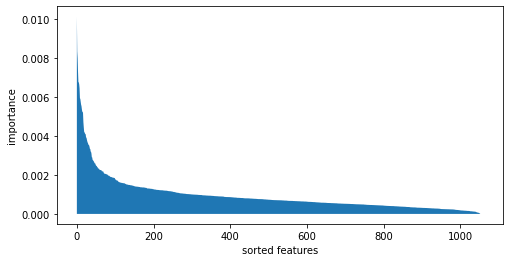

In [15]:
importances = pd.DataFrame(np.mean(cv_results['RF-N300DNoneL5']['importance'], axis = 0), \
                                   index = X_train_std.columns.values, columns = ['importance'])
importances.sort_values('importance', ascending = False, inplace = True)

plt.figure(figsize = (8, 4))
plt.fill_between(range(importances.shape[0]), np.zeros((importances.shape[0], )), importances.iloc[:, 0])
plt.xlabel('sorted features'); plt.ylabel('importance')
plt.show()

## Perform RFECV from the top features

In [16]:
base_estimator = RandomForestClassifier(n_estimators = 30, max_depth = None, min_samples_leaf = 5, random_state = 111)

top_features = list(importances.index.values[:70])
X_top_features = X_train_std.loc[:, [f for f in X_train_std.columns.values if f in top_features]]

rfecv = RFECV(base_estimator, step = 1, cv = 5, n_jobs = 4, importance_getter = 'auto').fit(X_top_features, y_train)

In [17]:
print('number of selected features:', len(X_top_features.columns.values[rfecv.support_]))

number of selected features: 36


### Perform another round of cross-validation

In [18]:
X_selected_features = X_top_features.loc[:, rfecv.support_]
rfe_cv_results = get_cv_results_tree(X_selected_features, y_train, random_forest_models)

In [19]:
X_selected_features

,TSH_Before_RT,TR_mean,v14,v25,v76,v208,v212,v240,v244,v290,...,v816,v829,v910,v940,v965,v1001,v1030,v1082,v1089,v1122
ID,,,,,,,,,,,,,,,,,,,,,
168,-0.206119,0.719568,0.029740,0.994476,-0.428894,-0.022760,0.029731,0.332034,-0.611960,0.029620,...,-0.016540,-0.202232,0.036306,0.029740,-0.058767,0.029814,-1.074118,-1.247552,0.163556,0.029740
85,-0.236501,-0.146551,0.921124,1.027954,0.860246,-0.406955,0.921135,0.115513,-0.614370,0.921109,...,0.782852,0.351185,0.968065,0.921124,0.467061,0.920744,0.038636,-1.708274,0.744116,0.921124
107,0.085258,1.053511,-0.225919,0.988811,-0.543972,-0.096368,-0.226096,-0.085618,-0.088928,-0.226258,...,-0.334286,-0.367982,-0.202039,-0.225919,-0.272965,-0.225484,0.586828,0.679397,-0.334727,-0.225919
217,-0.190129,-1.457928,-0.654394,-2.251442,0.338441,1.093636,-0.654445,-0.768485,1.071226,-0.654443,...,-0.612273,-0.566087,-0.604058,-0.654394,-0.594378,-0.654349,1.013349,0.296711,-0.582353,-0.654394
23,0.085258,-0.009314,-0.915497,1.025246,-0.541743,0.139272,-0.915516,0.252042,-0.205847,-0.915514,...,-0.858532,-0.871589,-0.897038,-0.915497,-0.905832,-0.914775,0.835447,-0.198060,-0.844470,-0.915497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.040841,-0.276164,0.247196,-0.486408,-0.124794,-1.123944,0.247204,-0.819386,0.701931,0.247141,...,0.201884,0.557771,0.203725,0.247196,0.424179,0.246788,-0.167549,0.312853,0.417292,0.247196
18,0.200743,0.188918,-1.012220,1.169961,-0.622240,1.167833,-1.012414,0.746761,-0.422487,-1.012492,...,-1.058054,-1.000667,-0.967279,-1.012220,-1.052687,-1.012515,1.149295,-0.483643,-1.133568,-1.012220
118,-0.233836,0.216365,-0.368506,1.151166,-0.521949,0.474405,-0.368684,0.771482,-0.968506,-0.368771,...,-0.500023,-0.593948,-0.392307,-0.368506,-0.545804,-0.368912,0.010746,-0.501899,-0.635692,-0.368506


In [20]:
# train group
models = [m for m in rfe_cv_results]
rfe_train_acc_all = [np.mean(rfe_cv_results[m]['train accuracy']) for m in rfe_cv_results]
rfe_train_auc_all = [np.mean(rfe_cv_results[m]['train AUC']) for m in rfe_cv_results]
rfe_train_acc_sd_all = [np.std(rfe_cv_results[m]['train accuracy']) for m in rfe_cv_results]
rfe_train_auc_sd_all = [np.std(rfe_cv_results[m]['train AUC']) for m in rfe_cv_results]

rfe_model_order = np.argsort(rfe_train_auc_all)[::-1]

for i in rfe_model_order:
    print(models[i], 'train acc =', rfe_train_acc_all[i], 'train AUC =', rfe_train_auc_all[i],
                     'train acc sd =', rfe_train_acc_sd_all[i], 'train AUC sd =', rfe_train_auc_sd_all[i])

RF-N50D10L1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 7.021666937153402e-17
RF-N300D10L1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 0.0
RF-N100D10L1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 0.0
RF-N100DNoneL1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 0.0
RF-N200D10L1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 4.965068306494546e-17
RF-N200D20L1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 0.0
RF-N200DNoneL1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 0.0
RF-N50DNoneL1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 4.965068306494546e-17
RF-N50D20L1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 4.965068306494546e-17
RF-N300D20L1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC sd = 4.965068306494546e-17
RF-N300DNoneL1 train acc = 1.0 train AUC = 1.0 train acc sd = 0.0 train AUC s

In [21]:
# validation group
models = [m for m in rfe_cv_results]
rfe_val_acc_all = [np.mean(rfe_cv_results[m]['test accuracy']) for m in rfe_cv_results]
rfe_val_auc_all = [np.mean(rfe_cv_results[m]['test AUC']) for m in rfe_cv_results]
rfe_val_acc_sd_all = [np.std(rfe_cv_results[m]['test accuracy']) for m in rfe_cv_results]
rfe_val_auc_sd_all = [np.std(rfe_cv_results[m]['test AUC']) for m in rfe_cv_results]

rfe_model_order = np.argsort(rfe_val_auc_all)[::-1]

for i in rfe_model_order:
    print(models[i], 'validation acc =', rfe_val_acc_all[i], 'validation AUC =', rfe_val_auc_all[i],
                     'validation acc sd =', rfe_val_acc_sd_all[i], 'validation AUC sd =', rfe_val_auc_sd_all[i])

RF-N50DNoneL1 validation acc = 0.7385714285714287 validation AUC = 0.8139662882696937 validation acc sd = 0.07334570087424823 validation AUC sd = 0.07179024357114967
RF-N50D20L1 validation acc = 0.7385714285714287 validation AUC = 0.8139662882696937 validation acc sd = 0.07334570087424823 validation AUC sd = 0.07179024357114967
RF-N50D10L1 validation acc = 0.7385714285714287 validation AUC = 0.8136394908840728 validation acc sd = 0.07334570087424823 validation AUC sd = 0.07290875396464622
RF-N300D10L1 validation acc = 0.733015873015873 validation AUC = 0.8087203302373581 validation acc sd = 0.06118342454169705 validation AUC sd = 0.053575028610699356
RF-N300DNoneL1 validation acc = 0.7444444444444446 validation AUC = 0.8083935328517372 validation acc sd = 0.05031520699976878 validation AUC sd = 0.05318827670769642
RF-N300D20L1 validation acc = 0.7444444444444446 validation AUC = 0.8083935328517372 validation acc sd = 0.05031520699976878 validation AUC sd = 0.05318827670769642
RF-N200DN

### Test set

In [22]:
bestRF_model = RandomForestClassifier(n_estimators = 50, max_depth = None, \
                               min_samples_leaf = 1, random_state = 119)
bestRF_model.fit(X_selected_features, y_train)

y_predict_feature_selected = bestRF_model.predict_proba(X_test_std.loc[:, X_selected_features.columns.values])[:, 1]
y_predict_class_feature_selected = bestRF_model.predict(X_test_std.loc[:, X_selected_features.columns.values])

print('with feature selection:')
print('accuracy:', accuracy_score(y_test, y_predict_class_feature_selected))
print('ROC AUC:', roc_auc_score(y_test, y_predict_feature_selected))

with feature selection:
accuracy: 0.7272727272727273
ROC AUC: 0.7453416149068323


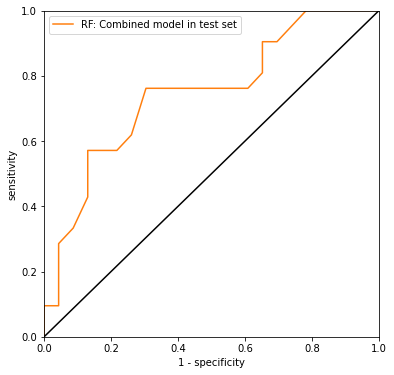

In [23]:
plt.figure(figsize = (6, 6))
    
fpr, tpr, thresholds = roc_curve(y_test, y_predict_feature_selected)
plt.plot(fpr, tpr, c = 'tab:orange', label = 'RF: Combined model in test set')

plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')
plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()

In [24]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_predict_class_feature_selected))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.70      0.76      0.73        21

    accuracy                           0.73        44
   macro avg       0.73      0.73      0.73        44
weighted avg       0.73      0.73      0.73        44



In [25]:
# lebel selected features
data = ['WL-LHH_ngtdm_Busyness', 'WL-HLH_glrlm_GrayLevelNonUniformity', 'WL-LHL_glrlm_GrayLevelNonUniformity',
        'log-sigma-2-0-mm-3D_glrlm_LowGrayLevelRunEmphasis','log-sigma-4-0-mm-3D_glcm_Idmn', 'WL-LHL_gldm_GrayLevelNonUniformity',
        'WL-LLH_glszm_ZoneEntropy', 'shape_VoxelVolume', 'WL-LHH_gldm_DependenceNonUniformity', 'log-sigma-4-0-mm-3D_firstorder_TotalEnergy',
        'WL-HHL_gldm_DependenceNonUniformity','log-sigma-5-0-mm-3D_glcm_Idn', 'glszm_LargeAreaHighGrayLevelEmphasis',
        'WL-LHL_glszm_LargeAreaHighGrayLevelEmphasis', 'WL-HLH_gldm_GrayLevelNonUniformity','log-sigma-2-0-mm-3D_glrlm_HighGrayLevelRunEmphasis',
        'log-sigma-3-0-mm-3D_glszm_ZoneEntropy', 'WL-HHH_firstorder_TotalEnergy', 'log-sigma-4-0-mm-3D_glcm_Idn', 'WL-HHL_firstorder_Skewness',
        'original_firstorder_Minimum','WL-HLH_firstorder_TotalEnergy','WL-LHL_firstorder_TotalEnergy', 'WL-LHL_gldm_DependenceNonUniformity',
        'WL-HLL_gldm_GrayLevelNonUniformity','WL-LLH_gldm_DependenceNonUniformity','Mean dose to thyroid gland', 'WL-LLH_glszm_SmallAreaEmphasis',
        'log-sigma-2-0-mm-3D_firstorder_Range', 'log-sigma-3-0-mm-3D_firstorder_Energy', 'WL-LHH_glszm_SizeZoneNonUniformityNormalized',
        'WL-LLH_glszm_SizeZoneNonUniformityNormalized', 'log-sigma-3-0-mm-3D_glcm_Idn', 'log-sigma-2-0-mm-3D_firstorder_TotalEnergy',
        'WL-HHL_glszm_SmallAreaEmphasis','TSH before RT']

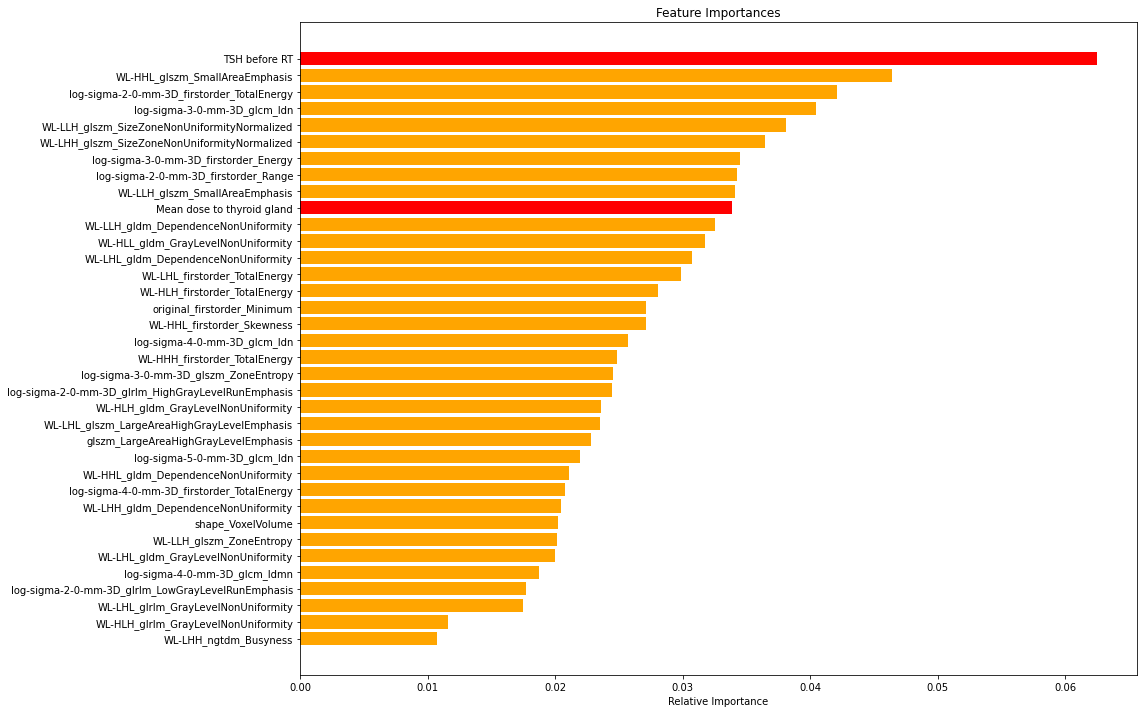

In [26]:
importances = bestRF_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (15, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=['orange', 'orange', 'orange', 'orange', 'orange', 'orange',
                               'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange',  
                            'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange',
                           'orange', 'r', 'orange', 'orange', 'orange',   'orange', 'orange', 'orange', 'orange', 'orange',
                           'r'], align='center')
plt.yticks(range(len(indices)), labels = data)
plt.xlabel('Relative Importance')
plt.show()